# Week 6 
## Exercises 1

In this exercise, we will explore some issues to consider when designing single cell RNA-seq experiments.

## 1. Droplet tuning

When performing scRNA-seq, we would like to design our experiment such that most of the time, each droplet will get exactly one bead and one cell. Then, we will get what we want: one unique barcode to denote each individual cell that was sequenced.

But occassionally, things can go wrong. For instance:

* Sometimes a droplet might not get a bead. Or it might not get a cell. If it doesn't get both of these things, we won't get any good data from that droplet.
* Sometimes, we might end up with two or more beads in a single droplet. This will result in some transcripts from the same cell being labeled with different barcodes.
* Sometimes, we might end up with two or more cells in a single droplet, which will both get the same barcode. This is called a ***technical doublet***.
* We might also end up with multiple different beads containing the same barcode in different droplets. If barcodes get repeated across droplets, we can get another form of doublets, called ***synthetic doublets***. In the data, this looks similar to the situation above: two cells got the same barcode.

Both beads and cells get loaded into droplets at a rate that follows a Poisson distribution:

$$ P(\text{droplet has j beads})  = \frac{e^{-\mu} \mu^j}{j!}$$
where $\mu$ is the mean number of beads loaded per droplet. Similarly:


$$ P(\text{droplet has k cells})  = \frac{e^{-\lambda} \lambda^k}{k!}$$
where $\lambda$ is the mean number of cells loaded per droplet. 

Then we can define:

* **cell capture rate**: is the probability that a droplet gets at least one bead. This is $1-P(\text{droplet has 0 beads})$, or $1-e^{-\mu}$ using the Poisson rate formula above
* **cell duplicate rate**: is the rate at which cells are associated with two ore more different barcodes. That is, what fraction of all droplets with at least one barcode actually have more than one barcode. This is equal to $\frac{P(\text{droplet has 2+ beads})}{P(\text{droplet has 1+ beads})}$, or $$\frac{1-e^{-\mu}-\mu e^{-\mu}}{1-e^{-\mu}}$$

We'd like to not waste any reagents, and make sure as many droplets as possible get a bead. On the other hand, we'd like to avoid putting more than one bead in a droplet, which will make our data messy. So, you can see we have a tradeoff! Too few beads is bad. Too many beads is also bad. The plot below illustrates this tradeoff:

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


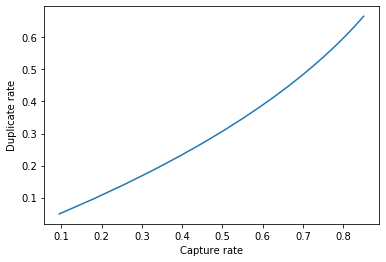

In [1]:
%pylab inline
import numpy as np
mus = np.arange(0, 2, 0.1)

capture_rates = [1-np.exp(-1*mu) for mu in mus]
dup_rates = [(1-np.exp(-1*mu)-mu*np.exp(-1*mu))/(1-np.exp(-1*mu)) for mu in mus]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(capture_rates, dup_rates)
ax.set_xlabel("Capture rate")
ax.set_ylabel("Duplicate rate");

A similar tradeoff exists when determining the number of cells per droplet (above the plot considers how many beads to use).

**Question 1 (2 pts)**: If we design our experiment such that on average each droplet gets 0.5 beads, how many droplets will get at least one bead? (i.e., what is the cell capture rate?). Set the variable `capture_rate` below to your answer.

In [4]:
capture_rate = 0 # set to your answer
# YOUR CODE HERE
cell_capture_rate = 1 - exp(-(0.5))

In [5]:
assert(cell_capture_rate > 0.35 and cell_capture_rate < 0.40)

**Question 2 (2 pts)**: For the same experiment, what will be the cell duplicate rate? Set the variable `duplicate_rate` to your answer below.

In [6]:
duplicate_rate = 0 # set to your answer
# YOUR CODE HERE
mu = 0.5
duplicate_rate = (1 - exp(-mu)-mu*exp(-mu))/(1-exp(-mu))

In [7]:
assert(duplicate_rate > 0.21 and duplicate_rate < 0.24)

**Question 3 (2 pts)**: You would like to design an experiment with capture rate of 0.4. You will generate 1 million droplets. How many beads should you use? Hint: $\mu$ is equal to the number of beads divided by the number of droplets. Set the variable `num_beads` to your answer below.

In [9]:
num_beads = 0 # set to your answer
# YOUR CODE HERE
#raise NotImplementedError()
#0.4 = 1 - exp(-mu)
#0.6 = e^-mu
#ln(-0.6) = -mu
mu = -math.log(0.6)
#mu = n_bead / n_droplets
num_beads = mu* 1000000

In [10]:
assert(num_beads > 500000 and num_beads < 600000)

## 2. Barcode design

There are several issues to keep in mind when designing barcodes for single cell experiments.

First, let's consider how many possible barcodes can be generated for a given length $L$. 10X barcodes are $L$=16bp long. In theory, that means we could have:

$$4^{16} \approx 4.3 \text{ billion}$$

possible barcodes. Note, we don't want to use every possible barcode. Instead, we want to choose barcodes such that even when there is a sequencing error reading the barcode, we would be able to tell there was an error and either discard or fix that barcode. One possible way to choose barcodes is to require that each pair of barcodes differ by at least two base pairs. That way, if there is a sequencing error changing one base, it won't match to any real barcodes and will be discarded. In practice, 10X uses around 750,000 barcodes.

Second, we would like to design barcodes such that it is highly unlikely that two cells will be captured separately by different beads containing the same barcode. Consider that we have $N$ cells and $M$ barcodes. The **barcode collision rate** is the expected percent of cells that do not have a unique barcode.

To compute this, let $p=1/M$. Then the probability that the same barcode is asociated with $k$ cells is:
$${N \choose k}p^k(1-p)^{N-k}$$
since each cell has $p$ chance to get a particular barcode $b$. So the probability a particular barcode is associated with exactly one cell is then:

$${N\choose 1}p(1-p)^{N-1} = \frac{N}{M}(1-\frac{1}{M})^{N-1}$$

Since there are $M$ possible barcodes, the expected number of cells with a unique barcode is:
$$N(1-\frac{1}{M})^{N-1}$$

and the collision rate is:
$$(1-\frac{1}{M})^{N-1} \approx 1-(\frac{1}{e})^{\frac{N}{M}}$$

So, the value of $\frac{N}{M}$ is key to determining the collision rate (or **synthetic doublet rate** using the terminology above). This value $\frac{N}{M}$ is referred to as the **relative barcode diversity**.

If this number is very high, we have many cells and few barcodes, so many barcodes will be repeated across cells resulting in many doublets. So we should try to keep this number low.

**Question 4 (2 pts)**: If we are sequencing 1 million cells and have 750,000 barcodes available, what percent of cells will not have a unique barcode? i.e. will the collision rate be (using the approximation above)? Set the variable `collision_rate` to your answer below. 

In [24]:
collision_rate = 0 # Set to your answer
# YOUR CODE HERE
M = 750000
N = 1000000
collision_rate = 1 - ((1/exp(1)))**(N/M)

In [25]:
assert(collision_rate>0.7 and collision_rate<0.8) # not good! most cells are doublets!

Recall that for a barcode of length $L$, we can generate $4^L$ possible unique barcodes. 

A question of interest is for a certain target collision rate, what is the minimum length barcode we can use?

Consider we would like a collision rate of at most 2%. A 2% doublet rate requires a barcode diversity rate of around 2%. Then based on the formula above we require the number of barcoes to be around 50 times the number of cells (so that $\frac{N}{M}=0.02$).

**Question 5 (2 pts)**: To assay 1 million cells with a collision rate of 2%, what is the minimum length of barcode we can use? Set the variable `min_length` below to your answer.

In [30]:
min_length = 0 # Set to your answer
# YOUR CODE HERE
N = 1000000
#0.02 = 1 - (1/e)^(N/M)
#0.98 = 1/e^(N/M)
#1/0.98 = e^(N/M)
#N/M = ln(1/0.98)
#M = N/(ln(1/0.98))
M = N/math.log(1/0.98)
#4^l = M
min_length = math.floor( math.log(M, 4) )

12

In [29]:
assert(min_length > 10 and min_length < 14)
assert(type(min_length)==int)

To see more info on these topics, see https://liorpachter.wordpress.com/2019/02/, where some of the material here was adapted from.